In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from ml_utils import get_stratified_train_test_split, get_stratified_kfold_cval_splits
from randomforest import RandomForest, DecisionTree, BiasedRandomForest

matplotlib.rcParams['figure.figsize'] = [20, 15]
datapath = "../diabetes.csv"
outpath = "../diabetes_processed.csv"

In [9]:
df = pd.read_csv(datapath)

In [10]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dcb8e10>,
      dtype=object)

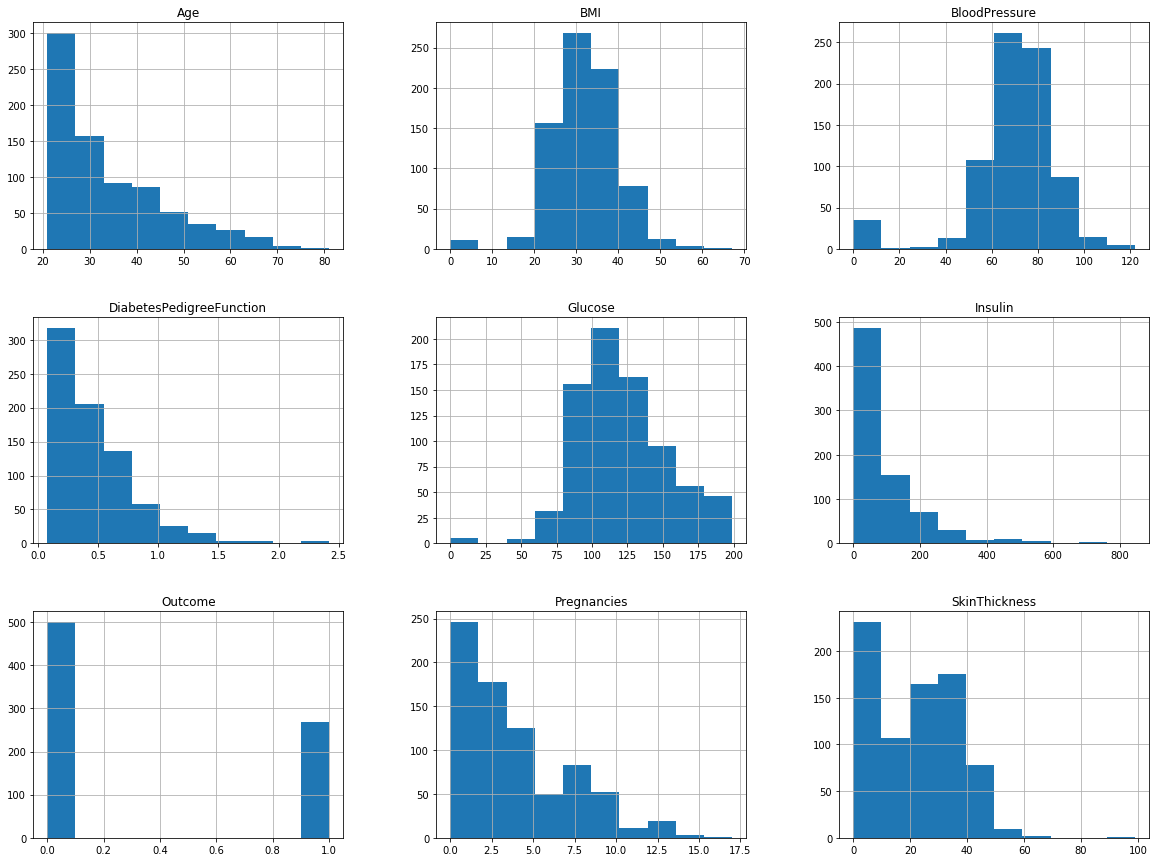

In [12]:
df.hist()


In [13]:
for colname in df.columns:
    print(colname, df[colname].isnull().sum())

Pregnancies 0
Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0
Outcome 0


No NaN values; lets make sure all values are valid. 

In [14]:
for colname in df.columns:
    print(colname, sum(df[colname]==0))

Pregnancies 111
Glucose 5
BloodPressure 35
SkinThickness 227
Insulin 374
BMI 11
DiabetesPedigreeFunction 0
Age 0
Outcome 500


Handling missing values:
* Since the number of people with 0 glucose, 0 BMI, or 0 blood pressure are low, I'll remove these. Some are correlated (some patients have 0 values for multiple metrics) so this will lead to a loss of fewer than 51 data points.
* Skin thickness and insulin have a lot of zeros that don't look in line with the distribution of the non-zero values, but the distribution of pregnancies look similar (judging only from the unimodality/bimodality of the KDEs; I didn't go as far as fitting exponential and normal distributions):

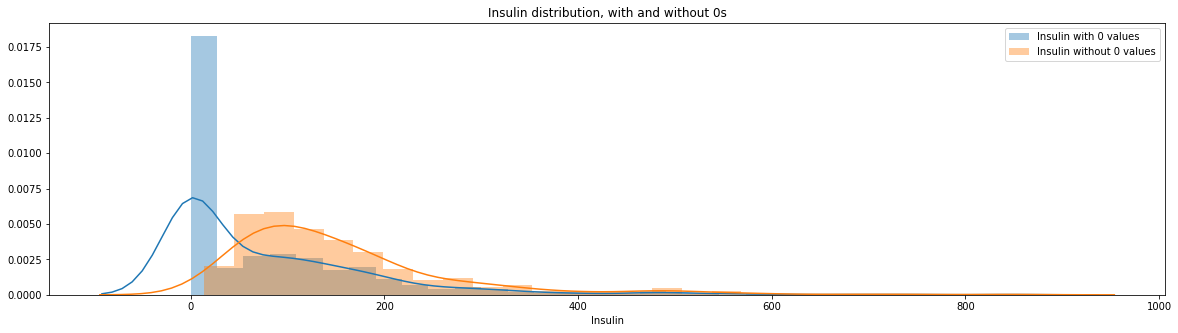

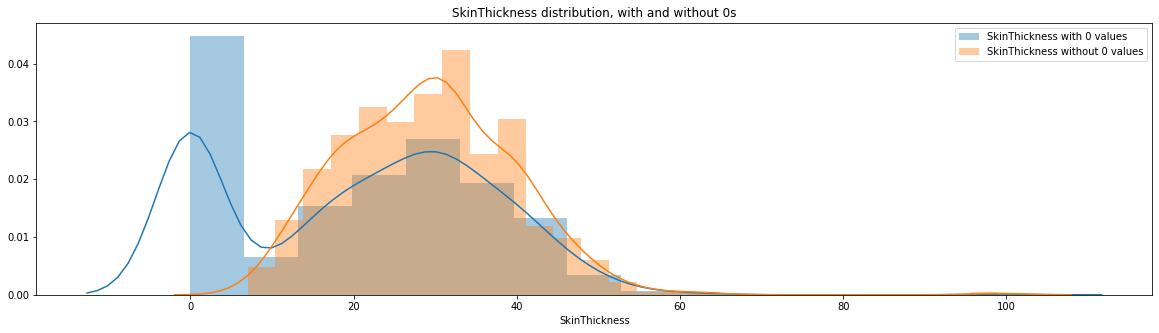

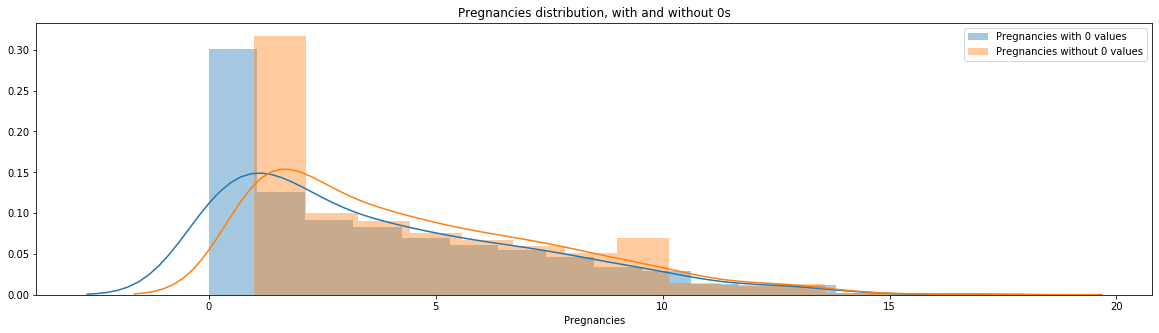

In [15]:
matplotlib.rcParams['figure.figsize'] = [20, 5]
for category in ['Insulin', 'SkinThickness', 'Pregnancies']:
    dist1 = df[category]
    dist2 = df[category][df[category]>0]
    sns.distplot(dist1)
    sns.distplot(dist2)
    plt.title(f"{category} distribution, with and without 0s");
    plt.legend([f'{category} with 0 values', f'{category} without 0 values'])
    plt.show()



Since we can't drop all of these, it's probably best to impute mean values for these. I would ideally implement a cluster-based imputation of values, but in the interest of time and to avoid data leakage I'll use the mean.

In [16]:
df.Insulin[df['Insulin']==0] = np.mean(df['Insulin'][df['Insulin']>0])
df.SkinThickness[df['SkinThickness']==0] = np.mean(df['SkinThickness'][df['SkinThickness']>0])

df = df[df['BMI']>0]
df = df[df['Glucose']>0]
df = df[df['BloodPressure']>0]

/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
for colname in df.columns:
    print(colname, sum(df[colname]==0))

Pregnancies 99
Glucose 0
BloodPressure 0
SkinThickness 0
Insulin 0
BMI 0
DiabetesPedigreeFunction 0
Age 0
Outcome 475


In [18]:
df.to_csv(outpath)

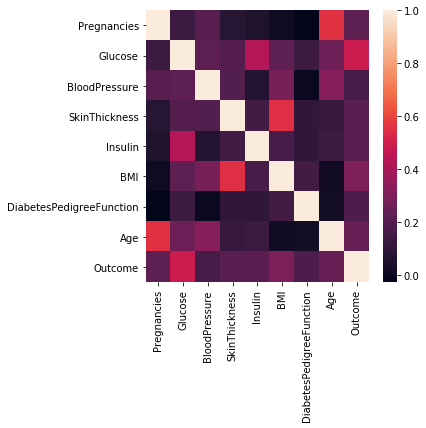

In [19]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
sns.heatmap(df.corr())

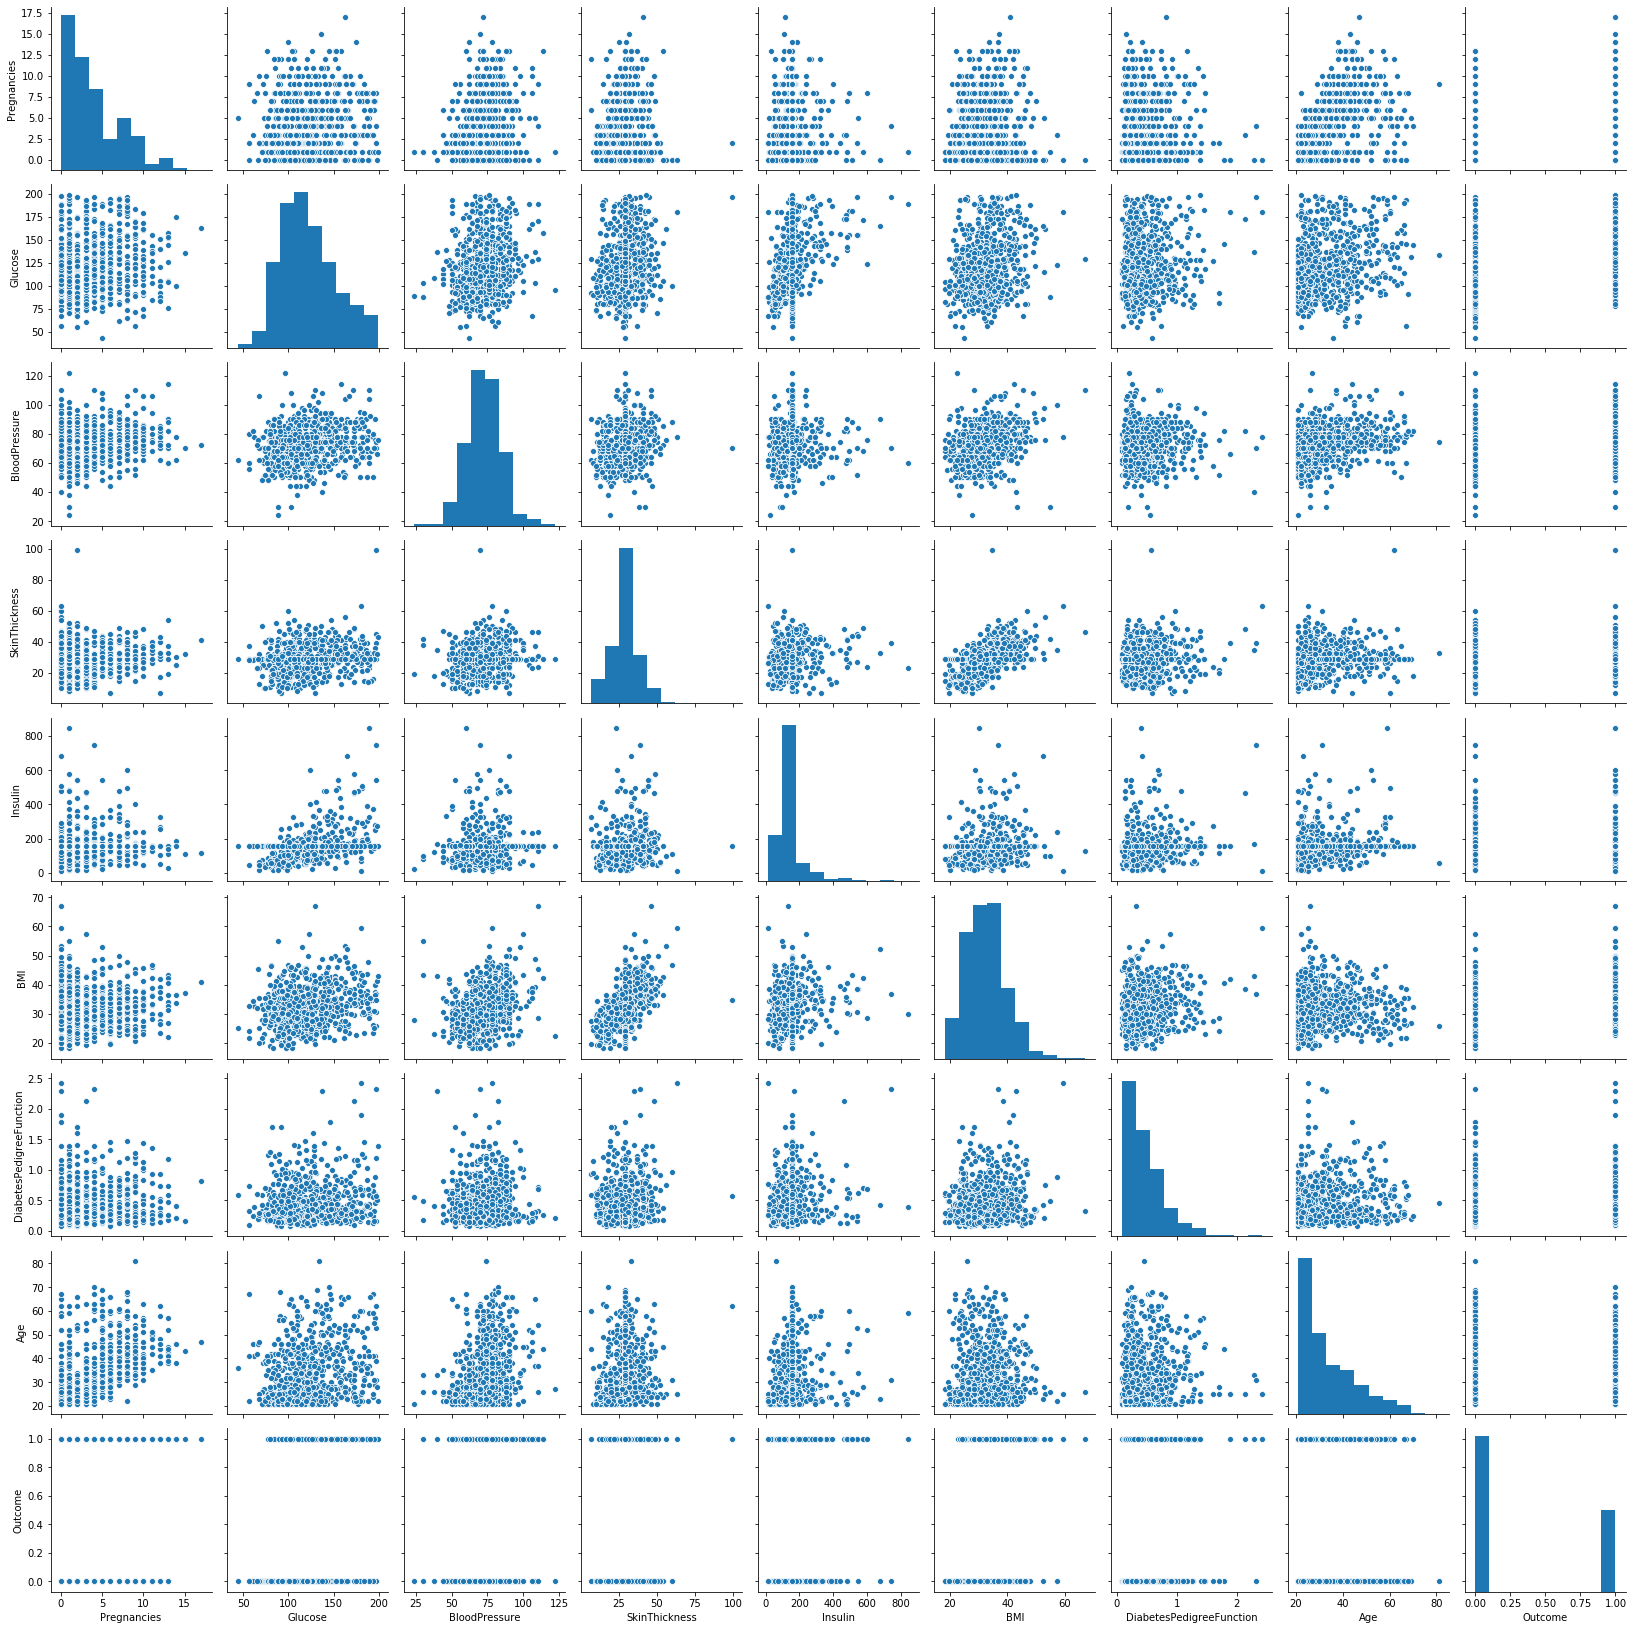

In [20]:
sns.pairplot(df)

## test knn approach

This is just to illustrate how with two very separable classes we get the knn subsample from the majority class. 

In [27]:
def get_knn_Maj_from_Min(data_x, data_y, k=10):
    yvals = data_y.values.flatten()
    majority_class = np.round(np.mean(yvals))
    min_inds = np.where(yvals!=majority_class)[0]
    maj_inds = np.where(yvals==majority_class)[0]
    min_set_x = data_x.iloc[min_inds]
    maj_set_x = data_x.iloc[maj_inds]
    min_set_y = data_y.iloc[min_inds]
    maj_set_y = data_y.iloc[maj_inds]
    dist_mat = scp.spatial.distance_matrix(min_set_x.values, maj_set_x.values) #setA, setB)
    knn = np.unique(np.array([np.argsort(i)[:k] for i in dist_mat]).flatten())
    maj_set_knn_x = maj_set_x.iloc[knn]
    maj_set_knn_y = maj_set_y.iloc[knn]
    return min_set_x.append(maj_set_knn_x), min_set_y.append(maj_set_knn_y) #setB[knn,:]

In [47]:
len(np.concatenate((np.random.rand(10,1), np.random.rand(10,1)),axis=1))

10

In [51]:
# setA = np.random.rand(30,2)
# setB = np.random.rand(300,2)*2+1
ndims=2
setA = np.concatenate(tuple([np.random.normal(0,1,size=[30,1]) for i in range(ndims)]),axis=1)
setB = np.concatenate(tuple([np.random.normal(4,2,size=[300,1]) for i in range(ndims)]),axis=1)

k = 10
dfA = pd.DataFrame(columns=['a','b'], data=setA)
dfB = pd.DataFrame(columns=['a','b'], data=setB)
dfX = pd.concat((dfA, dfB))
dfY = pd.DataFrame(columns=['y'], data=np.concatenate((np.zeros(len(setA)),np.ones(len(setB))), axis=0))


In [52]:
knn_x, knn_y = get_knn_Maj_from_Min(dfX, dfY, 3)

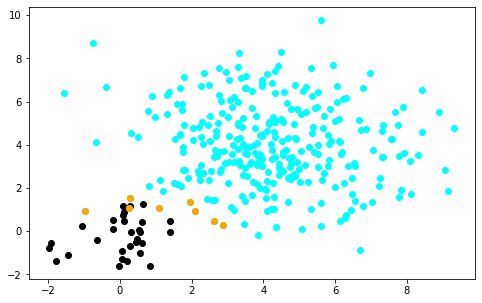

In [53]:
matplotlib.rcParams['figure.figsize'] = [8,5]
plt.scatter(dfX.values[np.where(dfY.values.flatten()==0)[0],0], dfX.values[np.where(dfY.values.flatten()==0)[0],1],color='black')
plt.scatter(dfX.values[np.where(dfY.values.flatten()==1)[0],0], dfX.values[np.where(dfY.values.flatten()==1)[0],1],color='aqua')
plt.scatter(knn_x.values[np.where(knn_y.values.flatten()==1)[0],0], knn_x.values[np.where(knn_y.values.flatten()==1)[0],1],color='orange')

## test forests

In [2]:
from randomforest import RandomForest, DecisionTree, BiasedRandomForest

# setA = np.random.rand(30,2)
# setB = np.random.rand(300,2)*2+1
ndims=4
setA = np.concatenate(tuple([np.random.normal(0,1,size=[30,1]) for i in range(ndims)]),axis=1)
setB = np.concatenate(tuple([np.random.normal(4,2,size=[270,1]) for i in range(ndims)]),axis=1)
colnames = list('abcdefghijklmnopqrstuvwxyz')[:ndims]
k = 10
dfA = pd.DataFrame(columns=colnames, data=setA)
dfB = pd.DataFrame(columns=colnames, data=setB)
dfX = pd.concat((dfA, dfB))
dfY = pd.DataFrame(columns=['y'], data=np.concatenate((np.zeros(len(setA)),np.ones(len(setB))), axis=0))

tr,te = get_stratified_train_test_split(dfY.values, int(len(dfY)*.6))
dfX_tr = dfX.iloc[tr]
dfY_tr = dfY.iloc[tr]
dfX_te = dfX.iloc[te]
dfY_te = dfY.iloc[te]

hparams={
    'max_depth': 100,
    'max_features': np.sqrt,
    'min_sample_leaf': 5,
    'ntrees':100,
    'k': 10,
    'p': .5,
    's': 100,
}
print(np.mean(dfY_tr.values))
print(np.mean(dfY_te.values))

0.9
0.9


In [3]:
dt = DecisionTree(data_x=dfX_tr, data_y=dfY_tr, max_depth=5, min_sample_leaf=5)
dt.make_tree()

/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
rf = RandomForest(data_x=dfX_tr, data_y=dfY_tr, hyper_params=hparams)
rf.make_forest()

In [5]:
braf = BiasedRandomForest(data_x=dfX_tr, data_y=dfY_tr, hyper_params=hparams)
braf.make_rfs()

In [6]:
for model_name, model in zip(['DecisionTree','RandomForest','BiasedRandomForest'],[dt, rf, braf]):
    predictions_model = []
    for i in range(len(dfX_te)):
        dat = dfX_te.iloc[i]
        predictions_model.append(np.round(model.predict(dat)))
    print(f'predictions from {model_name}:')
    print(predictions_model)
    print('prediction error rate: ')
    print(np.mean(np.abs(np.array(predictions_model)-dfY_te.values)))

predictions from DecisionTree:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
prediction error rate: 
0.18
predictions from RandomForest:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

## Run RF on PIMA

In [2]:
data=pd.read_csv(datapath)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
features = data.columns.drop('Outcome')
data_x = data[features]
data_y = data['Outcome']

In [4]:
train_fraction = .6
tr,te = get_stratified_train_test_split(data_y.values, int(len(data)*train_fraction))
data_x_tr = data_x.iloc[tr]
data_y_tr = data_y.iloc[tr]
data_x_te = data_x.iloc[te]
data_y_te = data_y.iloc[te]

In [5]:
hparams={
    'max_depth': 100,
    'max_features': np.sqrt,
    'min_sample_leaf': 5,
    'ntrees':100,
    'k': 10,
    'p': .5,
    's': 100,
}

In [7]:
print("Making DecisionTree:")
dt = DecisionTree(data_x=data_x_tr, data_y=data_y_tr, max_depth=hparams['max_depth'], 
                  min_sample_leaf=hparams['min_sample_leaf'])
dt.make_tree()
print("Making RandomForest:")
rf = RandomForest(data_x=data_x_tr, data_y=data_y_tr, hyper_params=hparams)
rf.make_forest()
print("Making BiasedRandomForest:")
braf = BiasedRandomForest(data_x=data_x_tr, data_y=data_y_tr, hyper_params=hparams)
braf.make_rfs()


Making DecisionTree:
Making RandomForest:
Making BiasedRandomForest:
predictions from DecisionTree:
[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,

In [24]:
all_predictions={'DecisionTree':[],
                 'RandomForest':[],
                 'BiasedRandomForest':[],
                }
for model_name, model in zip(['DecisionTree','RandomForest','BiasedRandomForest'],[dt, rf, braf]):
    predictions_model = []
    for i in range(len(data_x_te)):
        dat = data_x_te.iloc[i]
        predictions_model.append(model.predict(dat))
    all_predictions[model_name] = predictions_model
#     print(f'predictions from {model_name}:')
#     print(predictions_model)
    print(f'prediction error rate of {model_name}: ')
    print(np.mean(np.abs(np.array(predictions_model)-data_y_te.values)))

prediction error rate of DecisionTree: 
0.34772500464249884
prediction error rate of RandomForest: 
0.3053196803196804
prediction error rate of BiasedRandomForest: 
0.3053196803196804


/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


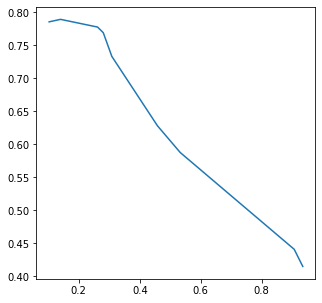

/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


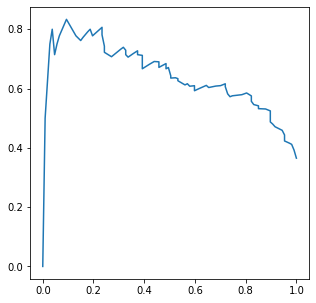

/Users/tamarmelman/opt/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


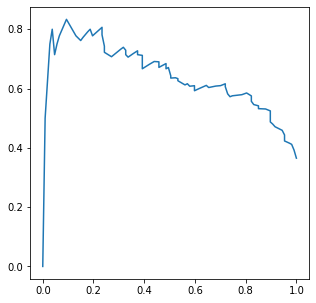

In [47]:
for model_name, predictions in all_predictions.items():
    roc = np.array(pr_curve(np.array(data_y_te.values), np.array(predictions)))
    plt.plot(roc[:,0],roc[:,1])
    plt.show()